In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import random
from pathlib import Path
from time import time
from datetime import datetime
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
from warnings import warn
from datetime import datetime
import itertools
from collections import Counter, OrderedDict
from bidi import algorithm as bidi
from hebrew_stopwords import hebrew_stopwords
import Parser

In [3]:
mpl.rcParams.update({'font.size': 13})

## Load data

In [4]:
%%time
DATA = Path('Data')
meta = pd.read_csv(DATA/'meta.csv')
df = pd.read_csv(DATA/'data.csv')

Wall time: 33.6 s


In [5]:
if len(meta)!=len(np.unique(df.ID)):
    warn(f'Inconsistent dimensions! {len(meta):d}!={len(np.unique(df.ID)):d}')

## Load topics sources and merge interesting staff to meta

In [6]:
TOPICS_PATH = Path('Data/topics')

In [11]:
dfs_topics = [pd.read_csv(TOPICS_PATH/f) for f in os.listdir(TOPICS_PATH) if f.endswith('.csv')]

In [14]:
for f,d in zip(os.listdir(TOPICS_PATH),dfs_topics):
    print(f, d.shape)
    print(d.columns)
    print()

data_committees_kns_cmtsessionitem_kns_cmtsessionitem.csv (47520, 8)
Index(['CmtSessionItemID', 'ItemID', 'CommitteeSessionID', 'Ordinal',
       'StatusID', 'Name', 'ItemTypeID', 'LastUpdatedDate'],
      dtype='object')

data_committees_kns_committeesession_kns_committeesession.csv (74355, 24)
Index(['CommitteeSessionID', 'Number', 'KnessetNum', 'TypeID', 'TypeDesc',
       'CommitteeID', 'Location', 'SessionUrl', 'BroadcastUrl', 'StartDate',
       'FinishDate', 'Note', 'LastUpdatedDate', 'download_crc32c',
       'download_filename', 'download_filesize', 'parts_crc32c',
       'parts_filesize', 'parts_parsed_filename', 'text_crc32c',
       'text_filesize', 'text_parsed_filename', 'topics', 'committee_name'],
      dtype='object')

data_committees_kns_committee_kns_committee.csv (750, 16)
Index(['CommitteeID', 'Name', 'CategoryID', 'CategoryDesc', 'KnessetNum',
       'CommitteeTypeID', 'CommitteeTypeDesc', 'Email', 'StartDate',
       'FinishDate', 'AdditionalTypeID', 'AdditionalT

In [16]:
dfs_topics[0].head()

,CmtSessionItemID,ItemID,CommitteeSessionID,Ordinal,StatusID,Name,ItemTypeID,LastUpdatedDate
0,29859,74042,66076,NaN,NaN,מסגרות להשמה חוץ ביתית לילדים בסיכון - סקירה,11,2012-09-20 22:23:47
1,29860,73194,66077,10.0,NaN,הפרסום בעיתון מעריב על שעות העבודה הרבות של נה...,11,2012-09-20 22:23:47
2,29861,72803,66084,10.0,NaN,מדידת המצויינות באוניברסיטאות המחקר,11,2012-09-20 22:23:47
3,29862,72802,66085,10.0,NaN,תנאי הקבלה לאוניברסיטאות,11,2012-09-20 22:23:47
4,29863,72801,66086,10.0,NaN,הקשר עם היהודים באמריקה הלטינית וחיזוק החינוך ...,11,2012-09-20 22:23:47


In [17]:
dfs_topics[1].head()

,CommitteeSessionID,Number,KnessetNum,TypeID,TypeDesc,CommitteeID,Location,SessionUrl,BroadcastUrl,StartDate,...,download_filename,download_filesize,parts_crc32c,parts_filesize,parts_parsed_filename,text_crc32c,text_filesize,text_parsed_filename,topics,committee_name
0,64990,NaN,15,161,פתוחה,25,"חדר הוועדה, באגף קדמה, קומה 1, חדר 1720",http://main.knesset.gov.il/Activity/committees...,NaN,2002-06-12 09:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""חוק הבחירות לכנסת (תיקון מס' 52), התשס\""ד-20...","החוקה, חוק ומשפט"
1,470756,NaN,18,161,פתוחה,661,"חדר הוועדה, באגף הוועדות (קדמה), קומה 2, חדר 2740",http://main.knesset.gov.il/Activity/committees...,NaN,2012-06-06 09:30:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""דו\""ח מבקר המדינה על ההתמודדות עם המשט הטורק...",לענייני ביקורת המדינה
2,470814,NaN,18,161,פתוחה,668,"חדר הוועדה, באגף הוועדות (קדמה), קומה 3, חדר 3710",http://main.knesset.gov.il/Activity/committees...,http://main.knesset.gov.il/Activity/committees...,2012-06-06 09:30:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""פניות ציבור בנוגע לתוכנית \""מנוחה בכבוד\"" של...",לפניות הציבור
3,471255,NaN,18,161,פתוחה,660,"חדר הוועדה, באגף הוועדות (קדמה), קומה 3, חדר 3730",http://main.knesset.gov.il/Activity/committees...,NaN,2012-06-13 09:30:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""תקנות אגרות בריאות (תיקון), התשע\""ב - 2012"",...","העבודה, הרווחה והבריאות"
4,471661,NaN,18,161,פתוחה,660,"חדר הוועדה, באגף הוועדות (קדמה), קומה 3, חדר 3730",http://main.knesset.gov.il/Activity/committees...,NaN,2012-06-20 09:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[""מעמדם של עובדי המכון למחקר ביולוגי בישראל""]","העבודה, הרווחה והבריאות"


In [ ]:
%%time
meta['CommitteeID'] = [dfs_topics[1].CommitteeID[dfs_topics[1].CommitteeSessionID==i].values[0]
                          for i in meta.CommitteeSessionID]
meta['committee_name'] = [dfs_topics[1].committee_name[dfs_topics[1].CommitteeSessionID==i].values[0]
                          for i in meta.CommitteeSessionID]

In [18]:
dfs_topics[2].head()

,CommitteeID,Name,CategoryID,CategoryDesc,KnessetNum,CommitteeTypeID,CommitteeTypeDesc,Email,StartDate,FinishDate,AdditionalTypeID,AdditionalTypeDesc,ParentCommitteeID,CommitteeParentName,IsCurrent,LastUpdatedDate
0,1,הכנסת,1.0,ועדת הכנסת,15,70,ועדת הכנסת,vadatk@knesset.gov.il,1999-06-07 00:00:00,NaN,991.0,קבועה,NaN,NaN,True,2017-04-24 16:47:06
1,2,הכספים,2.0,ועדת הכספים,15,71,ועדה ראשית,NaN,1999-06-07 00:00:00,NaN,991.0,קבועה,NaN,NaN,True,2015-03-20 12:02:57
2,3,החוץ והבטחון,4.0,ועדת החוץ והביטחון,15,71,ועדה ראשית,NaN,1999-06-07 00:00:00,NaN,991.0,קבועה,NaN,NaN,True,2015-03-20 12:02:57
3,4,הכלכלה,3.0,ועדת הכלכלה,15,71,ועדה ראשית,NaN,1999-06-07 00:00:00,NaN,991.0,קבועה,NaN,NaN,True,2015-03-20 12:02:57
4,5,הפנים ואיכות הסביבה,5.0,ועדת הפנים והגנת הסביבה,15,71,ועדה ראשית,NaN,1999-06-07 00:00:00,NaN,991.0,קבועה,NaN,NaN,True,2015-03-20 12:02:57


In [112]:
%%time
tmp = dfs_topics[2]
for cl in ('CategoryDesc','CommitteeTypeDesc','AdditionalTypeDesc'):
    meta[cl] = [tmp[tmp.CommitteeID==i][cl].values[0] for i in meta.CommitteeID]

Wall time: 58.9 s


In [19]:
dfs_topics[3].head()

,PersonID,LastName,FirstName,GenderID,GenderDesc,Email,IsCurrent,LastUpdatedDate
0,30299,נתונים,אין,251,זכר,NaN,True,2000-01-01 00:00:00
1,1026,אברהם-בלילא,רוחמה,250,נקבה,NaN,False,2015-03-20 12:03:08
2,1029,רצון,מיכאל,251,זכר,NaN,False,2015-03-20 12:03:08
3,1030,והבה,מגלי,251,זכר,NaN,False,2015-03-20 12:03:08
4,1031,אדרי,יעקב,251,זכר,NaN,False,2015-03-20 12:03:08


In [20]:
dfs_topics[4].head()

,mk_individual_id,committee_id,committee_name,position_id,position_name,start_date,finish_date,knesset
0,960,936,"ועדת העלייה, הקליטה והתפוצות",42,חבר ועדה,2019-01-09,NaN,20
1,970,922,ועדת הכספים,42,חבר ועדה,2019-01-09,NaN,20
2,92,2078,ועדה משותפת לוועדת הכנסת ולוועדת החוקה לדיון ב...,42,חבר ועדה,2019-01-01,NaN,20
3,208,2078,ועדה משותפת לוועדת הכנסת ולוועדת החוקה לדיון ב...,42,חבר ועדה,2019-01-01,NaN,20
4,754,2078,ועדה משותפת לוועדת הכנסת ולוועדת החוקה לדיון ב...,42,חבר ועדה,2019-01-01,NaN,20


### Show new columns

In [116]:
meta.fillna('', inplace=True)
meta.head()

,Unnamed: 0,ID,CommitteeSessionID,GroupTypeID,GroupTypeDesc,ApplicationID,ApplicationDesc,FilePath,LastUpdatedDate,KnessetNum,...,filesize,crc32c,error,i,date,committee_name,CommitteeID,CategoryDesc,CommitteeTypeDesc,AdditionalTypeDesc
0,0,71333,65782,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,16,...,82050,LLmkqg==,,0,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה
1,1,71335,66045,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:33,16,...,99662,wwtRjQ==,,1,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה
2,2,71336,66046,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,...,7113,ti5ZGA==,,2,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה
3,3,71337,66050,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,...,35967,Wyoukw==,,3,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה
4,4,71340,66166,23,פרוטוקול ועדה,1,DOC,http://fs.knesset.gov.il//16/Committees/16_ptv...,2010-06-02 20:32:34,16,...,57224,K+cm8w==,,4,2006-01-11,הכנסת,20,ועדת הכנסת,ועדת הכנסת,קבועה


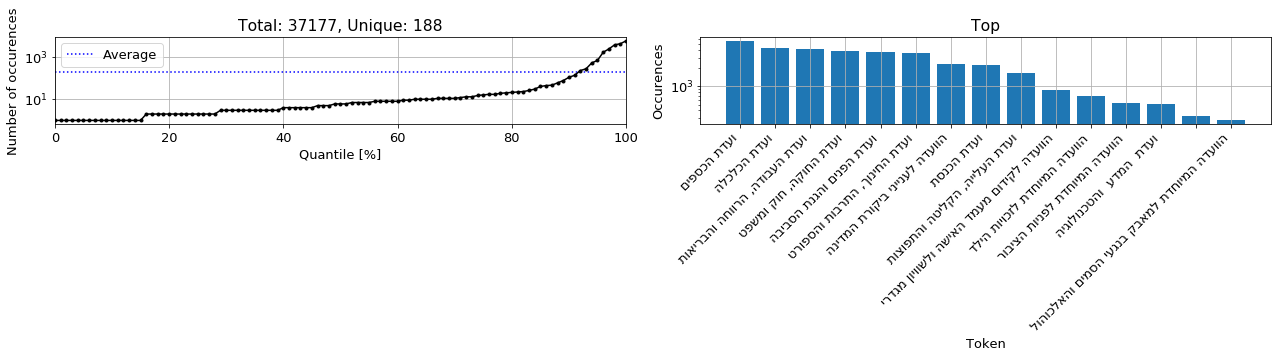

In [124]:
null = Parser.show_freqs(meta.CategoryDesc, compact=1, show_tail=0)

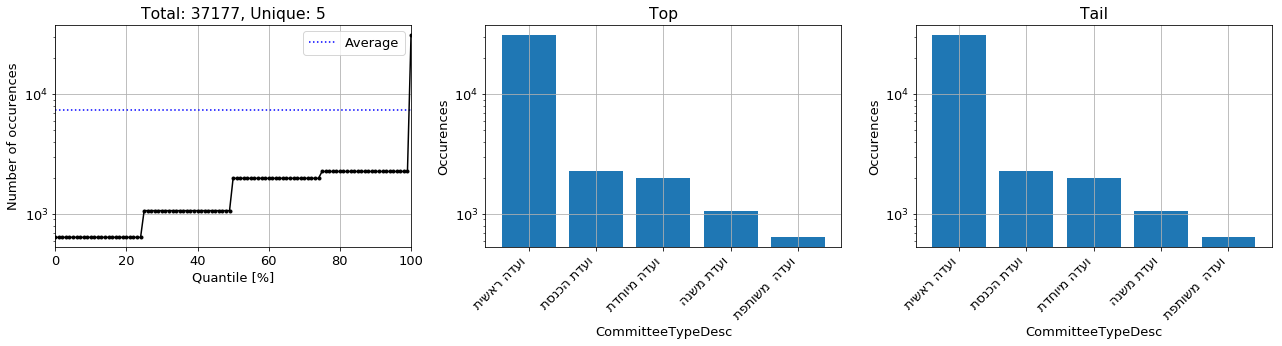

In [118]:
null = Parser.show_freqs(meta.CommitteeTypeDesc, compact=1, token_lab='CommitteeTypeDesc')

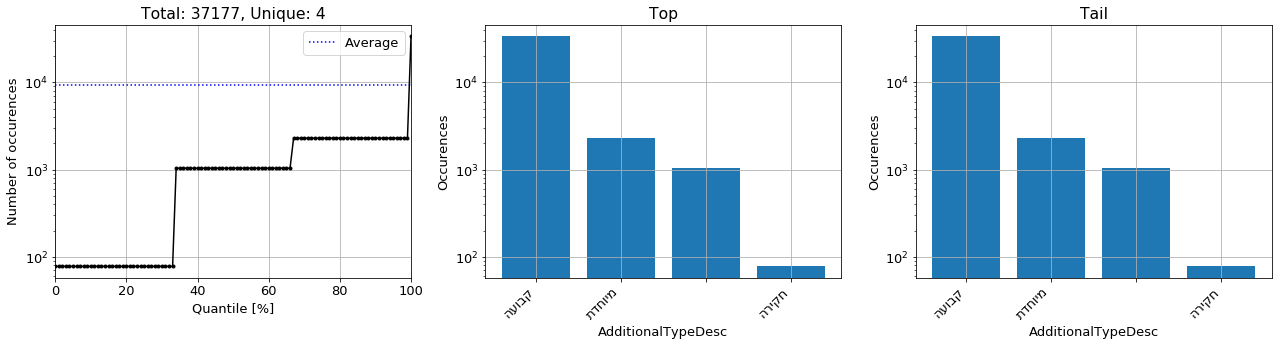

In [119]:
null = Parser.show_freqs(meta.AdditionalTypeDesc, compact=1, token_lab='AdditionalTypeDesc')

C:\Users\idogr\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


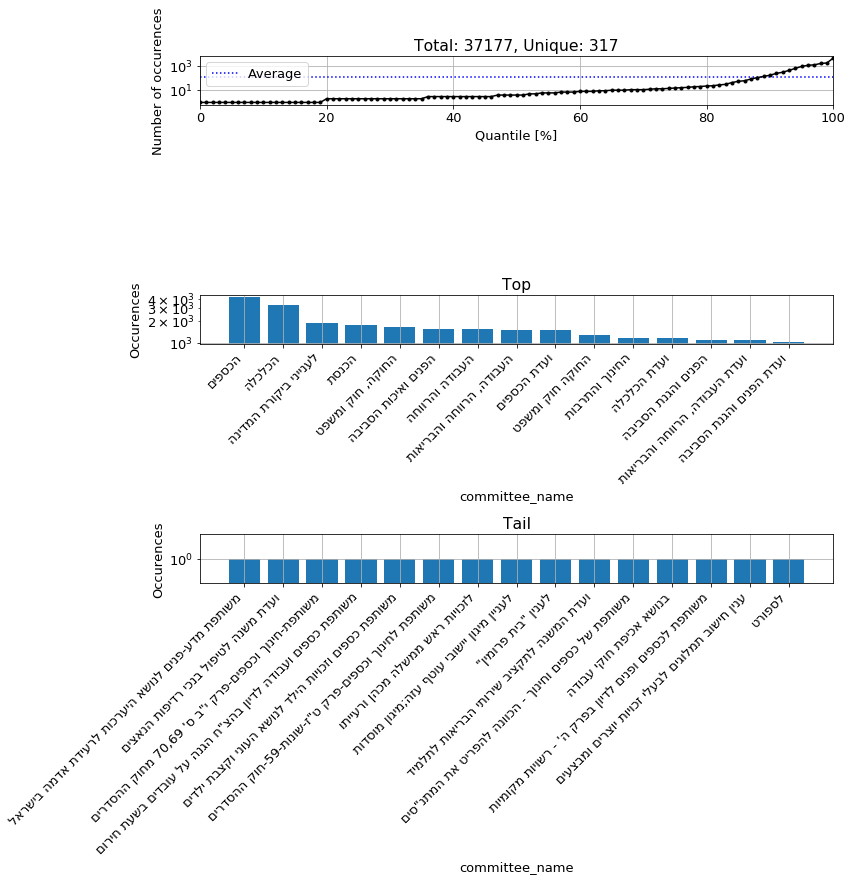

In [120]:
null = Parser.show_freqs(meta.committee_name, compact=0, token_lab='committee_name')

### Save metafile

In [125]:
meta.to_csv('Data/meta.csv', encoding='utf-8')